In [6]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

%matplotlib inline

/Users/miyoshi/tensorflow1.7/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [7]:
from model import Model
from data_manager import DataManager
from hd_cells import HDCells
from place_cells import PlaceCells

In [8]:
def load_checkpoints(sess):
    saver = tf.train.Saver(max_to_keep=2)
    save_dir = "./saved"
    checkpoint_dir = save_dir + "/checkpoints"
    
    checkpoint = tf.train.get_checkpoint_state(checkpoint_dir)
    if checkpoint and checkpoint.model_checkpoint_path:
        saver.restore(sess, checkpoint.model_checkpoint_path)

In [9]:
np.random.seed(1)
    
data_manager = DataManager()

place_cells = PlaceCells()
hd_cells = HDCells()

data_manager.prepare(place_cells, hd_cells)

model = Model(place_cell_size=place_cells.cell_size,
                          hd_cell_size=hd_cells.cell_size,
                          sequence_length=100)

sess = tf.Session()
sess.run(tf.global_variables_initializer())

# Load checkpoints
load_checkpoints(sess)

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See tf.nn.softmax_cross_entropy_with_logits_v2.

INFO:tensorflow:Restoring parameters from ./saved/checkpoints/checkpoint-54999


In [27]:
batch_size = 10
sequence_length = 100
resolution = 32
maze_extents = 4.5

activations = np.zeros([512, resolution, resolution], dtype=np.float32) # (512, 32, 32)
counts  = np.zeros([resolution, resolution], dtype=np.int32)        # (32, 32)

index_size = data_manager.get_confirm_index_size(batch_size, sequence_length)

for index in range(index_size):
    out = data_manager.get_confirm_batch(batch_size, sequence_length, index)
    inputs_batch, place_init_batch, hd_init_batch, place_pos_batch = out
            
    place_pos_batch = np.reshape(place_pos_batch, [-1, 2])
    # (1000, 2)
    
    g = sess.run(
            model.g,
            feed_dict = {
                model.inputs : inputs_batch,
                model.place_init : place_init_batch,
                model.hd_init : hd_init_batch,
                model.keep_prob : 1.0
            })
    
        
    for i in range(batch_size * sequence_length):
        pos_x = place_pos_batch[i,0]
        pos_z = place_pos_batch[i,1]
        x = (pos_x + maze_extents) / (maze_extents * 2) * resolution
        z = (pos_z + maze_extents) / (maze_extents * 2) * resolution
        counts[int(x), int(z)] += 1
        activations[:, int(x), int(z)] += np.abs(g[i, :]) # abs?

for x in range(resolution):
    for y in range(resolution):
        if counts[x, y] > 0:
            activations[:, x, y] /= counts[x, y]



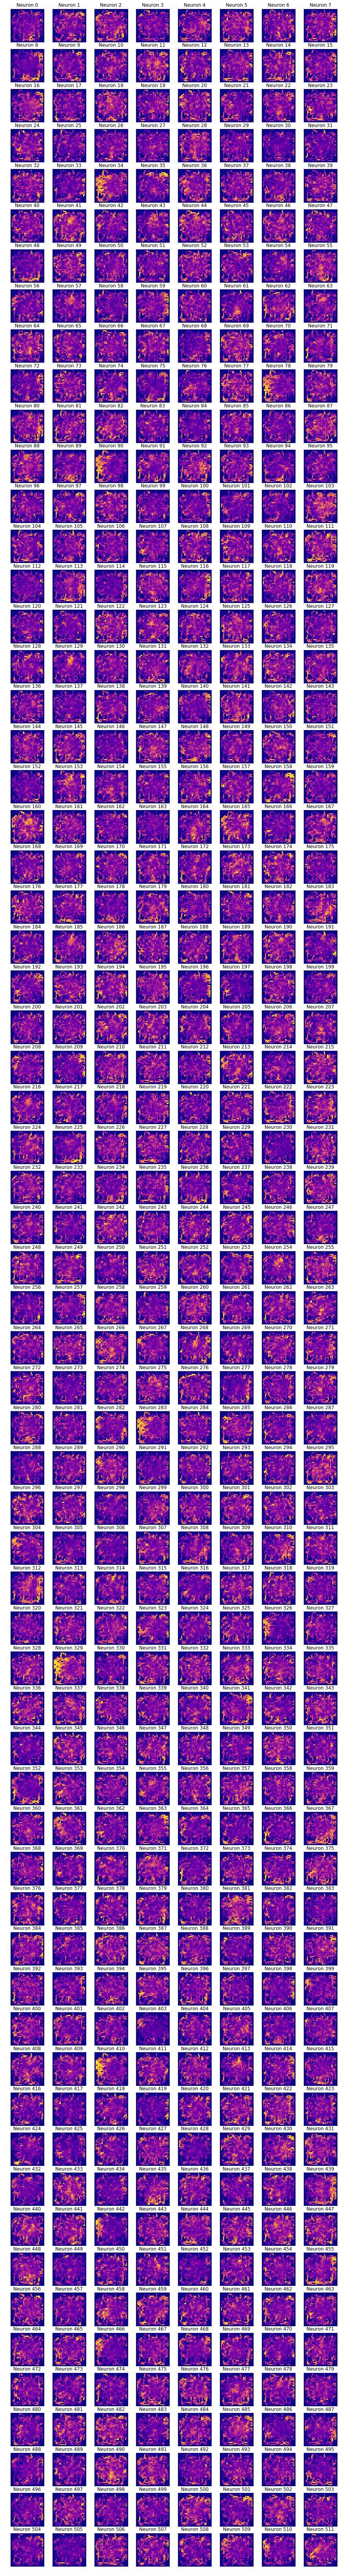

In [28]:
plt.figure(figsize=(15,30*4))
for i in range(512):
    plt.subplot(512//8, 8, 1 + i)
    plt.title('Neuron ' + str(i))
    plt.imshow(activations[i,:,:] / np.max(activations[i,:,:]), interpolation="nearest", cmap="plasma")
    plt.axis('off')    
plt.show()

In [32]:
np.c(counts)

47.8515625